# affichage des données labo

## import des bibliothèques

In [10]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import os

from datetime import datetime, timezone, timedelta, date
from sqlalchemy.engine import URL
from sqlalchemy.engine import create_engine
from sqlalchemy import text

import ipywidgets as widgets
from IPython.display import display as Idisplay
from ipywidgets.embed import embed_minimal_html

import warnings

In [2]:
warnings.filterwarnings('ignore')

## import des données

In [3]:
co_str = 'DRIVER={SQL Server Native Client 11.0};SERVER=ISTEF047756;DATABASE=donnees_labo;Trusted_Connection=yes;'
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": co_str})
engine = create_engine(connection_url)

with engine.connect() as conn :
    query = "SELECT * FROM Temperatures_machines_2 ORDER BY TIME_INDEX"
    Temp_mach = pd.read_sql(query, conn, parse_dates={"TIME_INDEX":{"format":"%Y-%m-%d %H/%M/%S:%f"}})

## affichage dynamique

In [4]:
dir(widgets)

['Accordion',
 'AppLayout',
 'Audio',
 'BoundedFloatText',
 'BoundedIntText',
 'Box',
 'Button',
 'ButtonStyle',
 'CallbackDispatcher',
 'Checkbox',
 'Color',
 'ColorPicker',
 'ColorsInput',
 'Combobox',
 'Controller',
 'CoreWidget',
 'DOMWidget',
 'DatePicker',
 'Datetime',
 'DatetimePicker',
 'Dropdown',
 'FileUpload',
 'FloatLogSlider',
 'FloatProgress',
 'FloatRangeSlider',
 'FloatSlider',
 'FloatText',
 'FloatsInput',
 'GridBox',
 'GridspecLayout',
 'HBox',
 'HTML',
 'HTMLMath',
 'Image',
 'IntProgress',
 'IntRangeSlider',
 'IntSlider',
 'IntText',
 'IntsInput',
 'Label',
 'Layout',
 'NaiveDatetimePicker',
 'NumberFormat',
 'Output',
 'Password',
 'Play',
 'RadioButtons',
 'Select',
 'SelectMultiple',
 'SelectionRangeSlider',
 'SelectionSlider',
 'SliderStyle',
 'Stack',
 'Style',
 'Tab',
 'TagsInput',
 'Text',
 'Textarea',
 'TimePicker',
 'ToggleButton',
 'ToggleButtons',
 'ToggleButtonsStyle',
 'TwoByTwoLayout',
 'TypedTuple',
 'VBox',
 'Valid',
 'ValueWidget',
 'Video',
 'Widge

### définition des widgets

In [5]:
start_date = widgets.NaiveDatetimePicker(description="date de début", value=datetime(2022, 1, 1))
end_date = widgets.NaiveDatetimePicker(description="date de fin", value=max(Temp_mach["TIME_INDEX"]))
columns = [widgets.Checkbox(description=col, value=False) for col in Temp_mach.columns[1:]]
accordion = widgets.Accordion(children=[widgets.VBox(columns)], selected_index = None)
accordion.set_title(0, "Machines à afficher")
m,M = 0, 120
Ycut = widgets.FloatRangeSlider(description="filtre", value=[m,M], min=0, max=120, step=0.1, readout_format='.1f')

Boxes_states = {k:False for k in Temp_mach.columns[1:]}
colors = ["orange", "C01",
              "lightblue", "lightskyblue", "deepskyblue", "dodgerblue", "royalblue",
              "mediumseagreen", "mediumaquamarine",
              "crimson"]
color_dict = {desc:c for desc,c in zip(Temp_mach.columns[1:],colors)}

In [6]:
COLORMAP = {"Etuve1":"orange",
            "Etuve2":"C01",
            "Refregirateur1":"lightblue", 
            "Refregirateur2":"lightskyblue", 
            "Refregirateur3":"deepskyblue", 
            "Refregirateur4":"dodgerblue", 
            "Refregirateur5":"royalblue",
            "Incubateur1":"mediumseagreen", 
            "Incubateur2":"mediumaquamarine",
            "Preleveur1":"crimson"}

In [7]:
class Displayer :
    DEFAULT_COLORS = COLORMAP
    
    def __init__(self, DS, fig, axis):
        self.dataset = DS
        self.X = DS["TIME_INDEX"]
        self.d_start = min(self.dataset["TIME_INDEX"])
        self.d_end = max(self.dataset["TIME_INDEX"])
        self.ymin = 100
        self.ymax = 120
        self.mask = np.full(len(self.X), True)
        self.plot_func = "plot"
        self.fig = fig
        self.ax = axis
        self.colors = self.DEFAULT_COLORS
        self.out = widgets.Output()
    
    def edit_colormap(self, key, color):
        self.colors[key] = color
    
    def change_plot_func(self, new_func):
        self.plot_func = new_func
    
    def change_dates(self, new_date_start=None, new_date_end=None):
        if new_date_start :
            self.d_start = new_date_start
        if new_date_end :
            self.d_end = new_date_end
        self._UPDATE_MASK()
    
    def change_ylim(self, new_ymin=None, new_ymax=None):
        if new_ymin :
            self.ymin = new_ymin
        if new_ymax :
            self.ymax = new_ymax
    
    def _UPDATE_MASK(self):
        self.mask = np.array([self.d_start <= date <= self.d_end for date in self.X])
    
    def _PLOT(self, Boxes):
        fig, ax = self.fig, self.ax
        ax.clear()
        for col,val in Boxes.items() :
            if val :
                M = self.mask * np.array([(not np.isnan(val)) and (self.ymin<=val<=self.ymax) for val in self.dataset[col]])
                ax.plot(self.X[M], 
                        self.dataset[col][M], 
                        color=self.colors[col],
                        label=col,
                        zorder=1)
        
        ax.tick_params(axis='x', rotation=90)
        ax.grid(zorder=0)
        ax.legend()
        fig.tight_layout()
        plt.show()
    
    def _SCATTER(self, Boxes):
        fig, ax = self.fig, self.ax
        ax.clear()
        for col,val in Boxes.items() :
            if val :
                M = self.mask * np.array([(not np.isnan(val)) and (self.ymin<=val<=self.ymax) for val in self.dataset[col]])
                ax.scatter(self.X[M], 
                           self.dataset[col][M], 
                           color=self.colors[col],
                           s=list([50,20,5]+[1]*5)[int(np.log10(len(self.X[M])))],
                           label=col,
                           zorder=1)
        ax.tick_params(axis='x', rotation=90)
        ax.grid(zorder=0)
        ax.legend()
        fig.tight_layout()
        plt.show()
    
    def _BOXPLOT(self, Boxes):
        fig, ax = self.fig, self.ax
        ax.clear()
        input_data = {}
        for col,val in Boxes.items() :
            if val :
                M = self.mask * np.array([(not np.isnan(val)) and (self.ymin<=val<=self.ymax) for val in self.dataset[col]])
                input_data[col] = self.dataset[col][M]
        ax.boxplot(x=input_data.values(), 
                   vert=True,
                   labels = input_data.keys(), 
                   meanline=True,
                   sym='')
        
        ax.tick_params(axis='x', rotation=90)
        fig.tight_layout()
        plt.show()
    
    def _VIOLINPLOT(self, Boxes):
        fig, ax = self.fig, self.ax
        ax.clear()
        input_data = {}
        for col,val in Boxes.items() :
            if val :
                M = self.mask * np.array([(not np.isnan(val)) and (self.ymin<=val<=self.ymax) for val in self.dataset[col]])
                input_data[col] = self.dataset[col][M]
        sns.violinplot(data=list(input_data.values()),
                       ax=ax)
        
        ax.tick_params(axis='x', rotation=90)
        fig.tight_layout()
        plt.show()

    def display(self, Boxes):
        self.out.clear_output()
        with self.out :
            if self.plot_func == "plot" :
                self._PLOT(Boxes)
            if self.plot_func == "scatter" :
                self._SCATTER(Boxes)
            if self.plot_func == "boxplot" :
                self._BOXPLOT(Boxes)
            if self.plot_func == "violinplot" :
                self._VIOLINPLOT(Boxes)
        Idisplay(self.out)

<IPython.core.display.Javascript object>


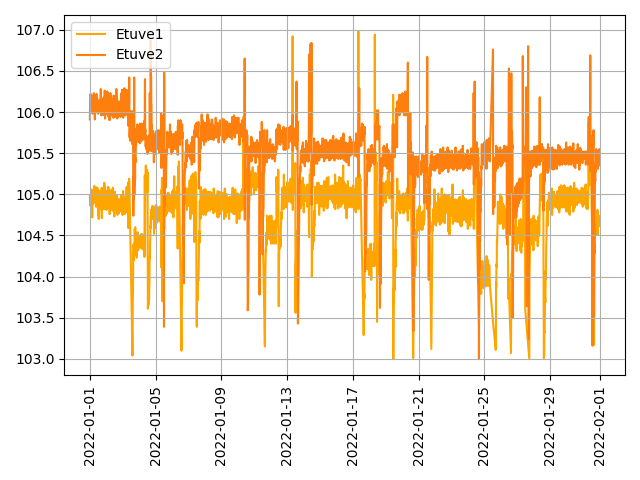

NaiveDatetimePicker(value=datetime.datetime(2022, 1, 1, 0, 0), description='date de début')

NaiveDatetimePicker(value=Timestamp('2022-09-15 16:40:00'), description='date de fin')

Accordion(children=(VBox(children=(Checkbox(value=False, description='Etuve1'), Checkbox(value=False, descript…

FloatRangeSlider(value=(0.0, 120.0), description='filtre', max=120.0, readout_format='.1f')

Output()

Output(outputs=({'output_type': 'stream', 'text': 'No artists with labels found to put in legend.  Note that a…

Output()

Output(outputs=({'output_type': 'stream', 'text': 'No artists with labels found to put in legend.  Note that a…

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [8]:
fig, ax = plt.subplots()

D = Displayer(Temp_mach, fig, ax)

def start_date_eventhandler(change):
    D.change_dates(change.new)
    D.display(Boxes_states)
def end_date_eventhandler(change):
    D.change_dates(new_date_end=change.new)
    D.display(Boxes_states)
def checkboxes_column_eventhandler(desc, change):
    if isinstance(change['new'], dict) and change['new'] :
        Boxes_states[desc]=change['new']['value']
        D.display(Boxes_states)
def checkbox_eventhandler(change):
    checkboxes_column_eventhandler(change['owner'].description, change)
def FloatRangeSlider_eventhandler(change):
    D.change_ylim(change.new[0], change.new[1])
    D.display(Boxes_states)

start_date.observe(start_date_eventhandler, names='value')
end_date.observe(end_date_eventhandler, names='value')
Ycut.observe(FloatRangeSlider_eventhandler, names='value')
for el in columns :
    el.observe(checkbox_eventhandler)

Idisplay(start_date, end_date, accordion, Ycut)